In [1]:
# Importing the libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tester as tests
import tarfile
import pickle
from sklearn.preprocessing import LabelBinarizer
import tensorflow  as tf

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

#Importing the Dataset

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 10:
Image - Min Value: 24 Max Value: 130
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


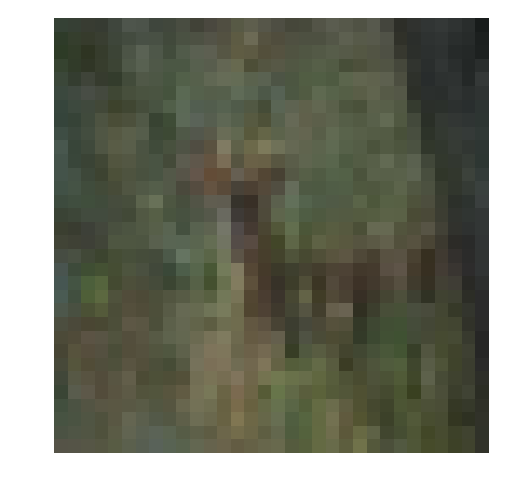

In [3]:
# Explore the dataset
batch_id = 1
sample_id = 10
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [5]:
# Normalize a list of sample image data in the range of 0 to 1
def normalize(x):
    return x / 255

In [4]:
# One hot encode a list of sample labels
# The possible values for labels are 0 to 9. 10 in total
def one_hot_encode(x):
    return np.eye(10)[x] 

In [6]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [8]:
# Helper functions for 
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=[None, *image_shape], name = "x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name = "y")


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")


In [9]:
tf.reset_default_graph()

In [11]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):

    input_depth = x_tensor.shape[-1].value

    weights = tf.Variable( tf.truncated_normal( shape=[ conv_ksize[0], conv_ksize[1], input_depth, conv_num_outputs], 
            mean=0.0, stddev=0.1), name='weights') 
    
    bias = tf.Variable(tf.zeros(conv_num_outputs), trainable=True)
    
    # Adding Convolution layer
    conv_layer = tf.nn.conv2d(x_tensor, weights, strides=[1, *conv_strides, 1], padding='SAME')
    
    # Adding Bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    # Adding ReLu
    conv_layer = tf.nn.relu(conv_layer)
    
    # Applying Max Pooling
    conv_layer = tf.nn.max_pool(conv_layer, ksize=[1, *pool_ksize, 1], strides=[1, *pool_strides, 1], padding='SAME')
    
    return conv_layer 


In [12]:
#  Flattening the x_tensor to (Batch Size, Flattened Image Size)
def flatten(x_tensor):
    return tf.reshape(x_tensor, [-1, x_tensor.get_shape()[1:4].num_elements()])


In [13]:
# Defining fully connected layer
def  fully_conn(x_tensor, num_outputs):
    
    batch_size = x_tensor.shape[1].value
    
    weights = tf.Variable( tf.truncated_normal( [batch_size, num_outputs], mean = 0, stddev=0.1))
    
    bias = tf.Variable(tf.zeros(num_outputs))

    fully_conn_layer = tf.matmul(x_tensor, weights)
    fully_conn_layer = tf.nn.bias_add(fully_conn_layer, bias)
    fully_conn_layer = tf.nn.relu(fully_conn_layer)

    return fully_conn_layer


In [15]:
# Defining output layer
def output(x_tensor, num_outputs):
   
    batch_size = x_tensor.shape[1].value
    weights = tf.Variable( tf.truncated_normal( [batch_size, num_outputs], mean = 0, stddev=0.1))    
    bias = tf.Variable(tf.zeros(num_outputs))
    
    output_layer = tf.matmul(x_tensor, weights)
    output_layer = tf.nn.bias_add(output_layer, bias)
    
    return output_layer

In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_num_outputs_layer1 = 32
    conv_num_outputs_layer2 = 64
    conv_num_outputs_layer3 = 128
    fully_conn_num_outputs_layer_1 = 256
    fully_conn_num_outputs_layer_2 = 512
    conv_ksize = (5, 5)
    conv_strides = (1, 1)
    pool_ksize = (2, 2)
    pool_strides = (2, 2)
    
    common_params = [conv_ksize, conv_strides, pool_ksize, pool_strides]
    
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    conv_layer_1 = conv2d_maxpool(x, conv_num_outputs_layer1, *common_params)
    conv_layer_1 = tf.nn.dropout(conv_layer_1, keep_prob)
    
    conv_layer_2 = conv2d_maxpool(conv_layer_1, conv_num_outputs_layer2, *common_params)
    conv_layer_2 = tf.nn.dropout(conv_layer_2, keep_prob)
    
    conv_layer_3 = conv2d_maxpool(conv_layer_2, conv_num_outputs_layer3, *common_params)
    conv_layer_3 = tf.nn.dropout(conv_layer_3, keep_prob)
    
    # Apply a Flatten Layer
    flatten_layer_1 = flatten(conv_layer_3)

    # Apply 1, 2, or 3 Fully Connected Layers
    fully_conn_layer_1 = fully_conn(flatten_layer_1, fully_conn_num_outputs_layer_1)
    fully_conn_layer_1 = tf.nn.dropout(fully_conn_layer_1, keep_prob)
    fully_conn_layer_2 = fully_conn(flatten_layer_1, fully_conn_num_outputs_layer_2)
    fully_conn_layer_2 = tf.nn.dropout(fully_conn_layer_2, keep_prob)
    
    
    # Apply an Output Layer
    num_outputs = 10 # 10 classes
    output_layer = output(fully_conn_layer_2, num_outputs)
    
    return output_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Neural Network Built!


In [18]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print("Loss: {} Accuracy: {}".format(loss, accuracy))

In [16]:
epochs = 35
batch_size = 128
keep_probability = 0.75

In [21]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.1440582275390625 Accuracy: 0.2533999979496002
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.9853413105010986 Accuracy: 0.37299999594688416
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.8013499975204468 Accuracy: 0.40619999170303345
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.707615613937378 Accuracy: 0.43799999356269836
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.6751010417938232 Accuracy: 0.4440000057220459
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.6000149250030518 Accuracy: 0.46700000762939453
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.5259202718734741 Accuracy: 0.4796000123023987
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.433312177658081 Accuracy: 0.4878000020980835
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.3200740814208984 Accuracy: 0.4970000088214874
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.2183377742767334 Accuracy: 0.5072000026702881
Epoch 11, CIFAR-10 Batch 1:  Loss: 1.1643009185791016 Accuracy: 0.524399995803833
Epoch 12, CIFAR-10 Batch 1:  Loss: 1.124245

In [17]:
 save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.1205525398254395 Accuracy: 0.2736000120639801


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()